Encoding ocean proximity  
price range added  
visualized data  

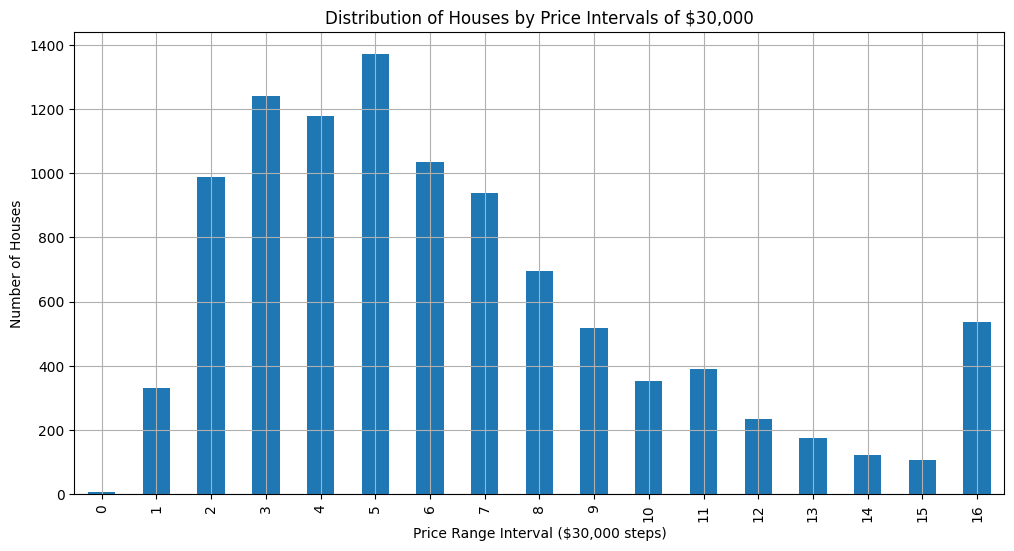

Updated CSV file saved to: housing_updated.csv


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

housing = pd.read_csv('housing.csv')
housing = housing.dropna()


ocean_proximity_mapping = {
    '<1H OCEAN': 3,
    'NEAR OCEAN': 2,
    'NEAR BAY': 1,
    'INLAND': 0
}
housing['ocean_proximity'] = housing['ocean_proximity'].map(ocean_proximity_mapping)
housing = housing.dropna()

max_value = housing['median_house_value'].max()
bins = np.arange(0, max_value + 30000, 30000)

housing['price_range'] = pd.cut(housing['median_house_value'], bins=bins, labels=False, right=False)

housing = housing.drop(columns=['median_house_value'])

housing, _ = train_test_split(housing, test_size=0.5, stratify=housing['price_range'], random_state=42)

output_path = 'housing_updated.csv'
housing.to_csv(output_path, index=False)

housing = pd.read_csv('housing_updated.csv')


plt.figure(figsize=(12,6))
housing['price_range'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Price Range Interval ($30,000 steps)')
plt.ylabel('Number of Houses')
plt.title('Distribution of Houses by Price Intervals of $30,000')
plt.grid(True)
plt.show()

# Output file path
print(f"Updated CSV file saved to: {output_path}")


Plot individual features and their relationship with the target variable.  

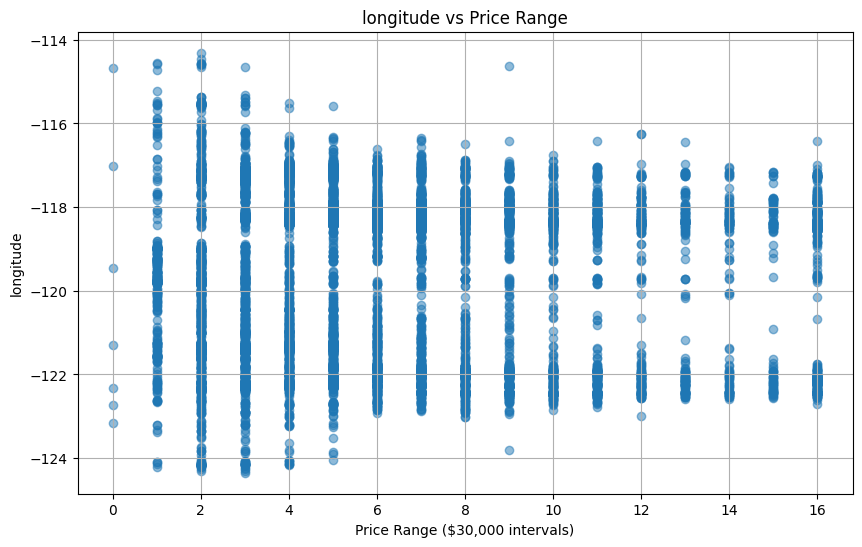

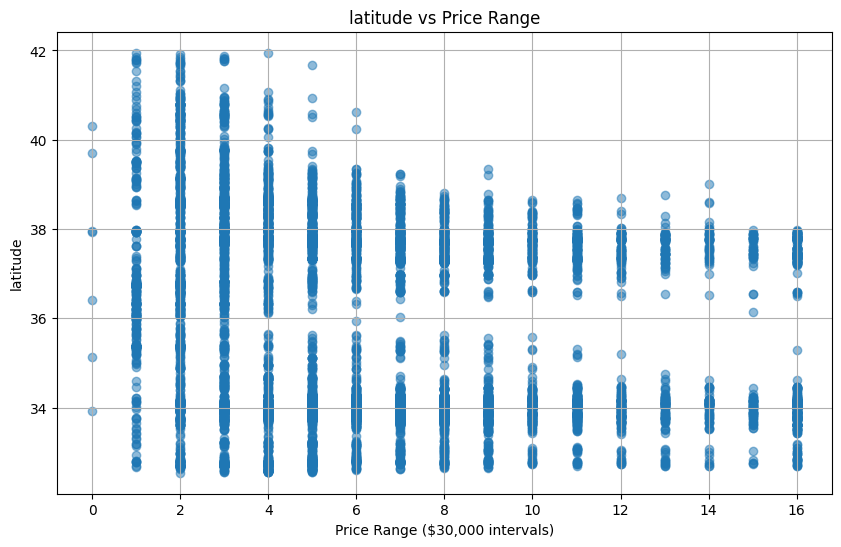

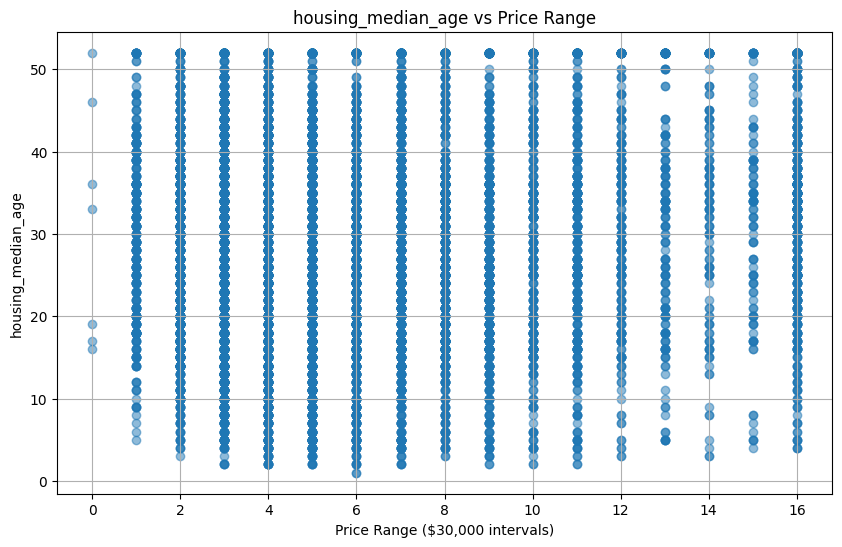

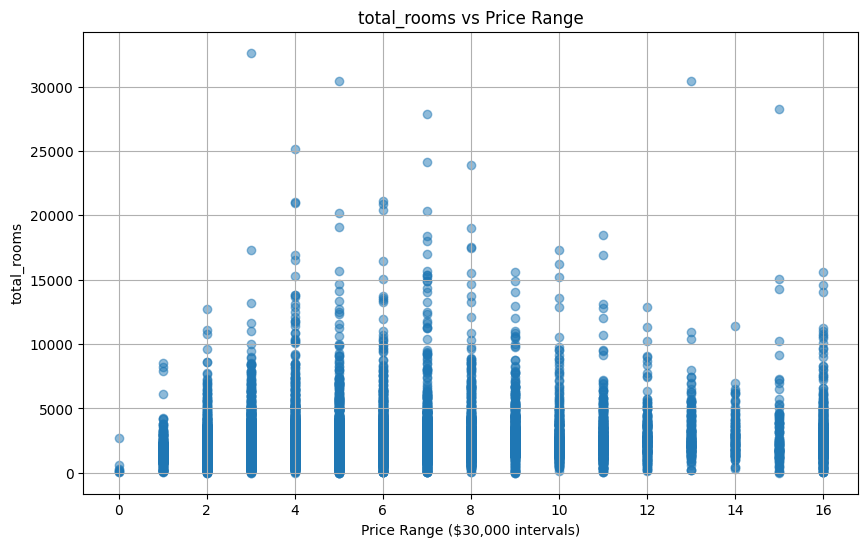

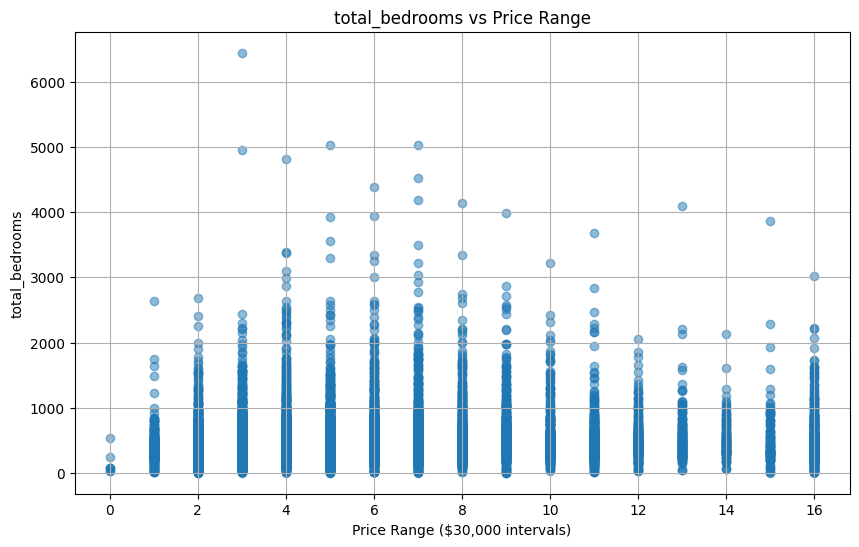

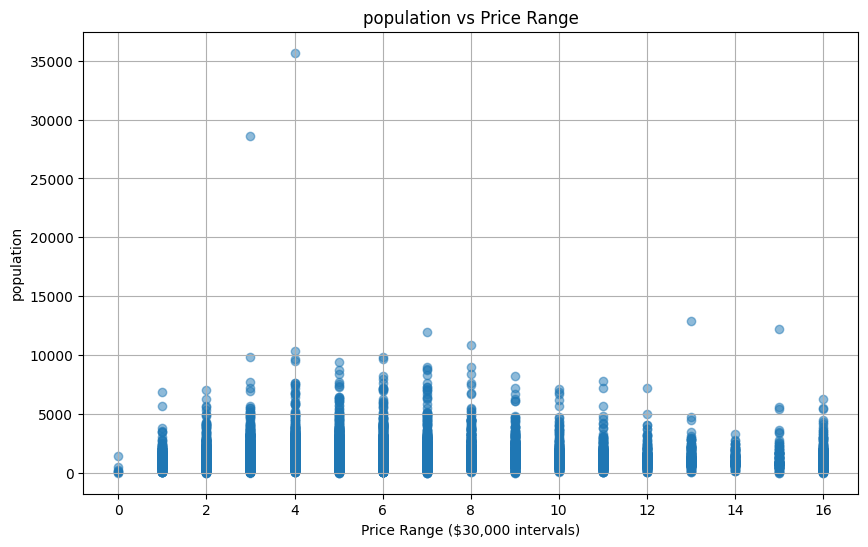

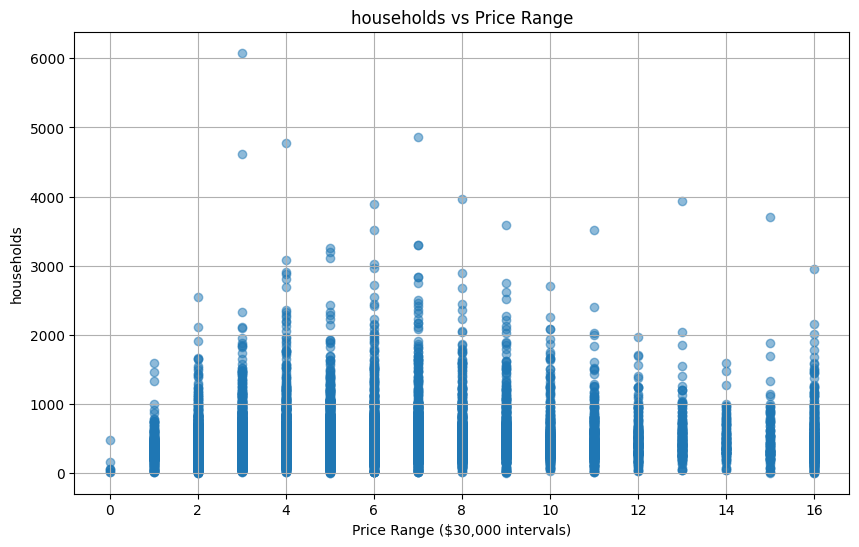

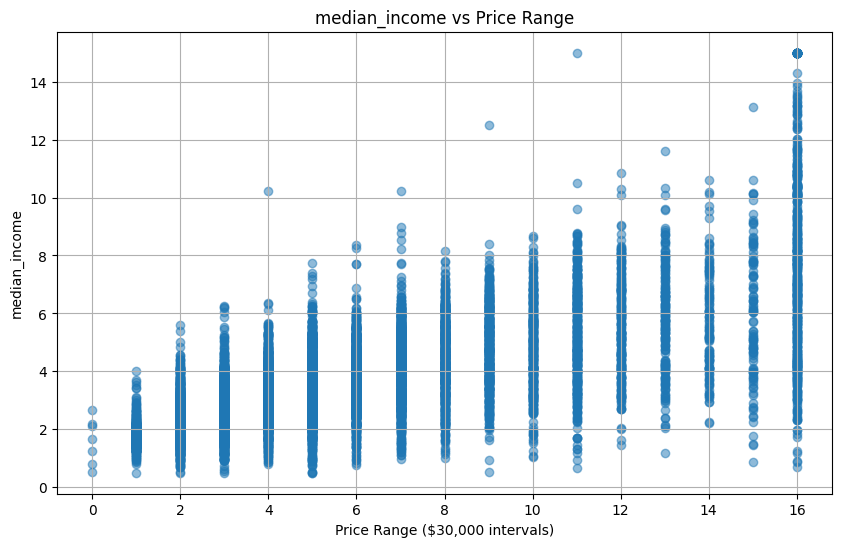

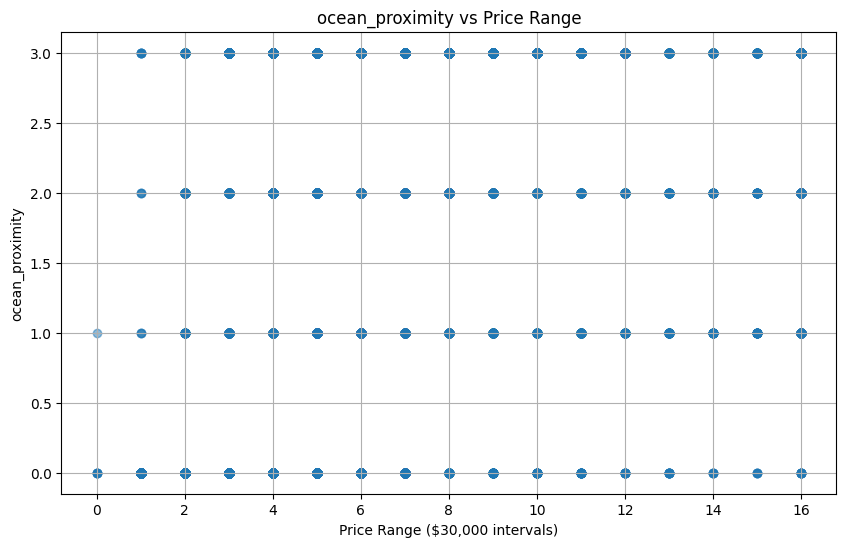

In [35]:
features = housing.columns.drop('price_range')

for feature in features:
    plt.figure(figsize=(10, 6))
    plt.scatter(housing['price_range'], housing[feature], alpha=0.5)
    plt.xlabel('Price Range ($30,000 intervals)')
    plt.ylabel(feature)
    plt.title(f'{feature} vs Price Range')
    plt.grid(True)
    plt.show()

correlation matrix

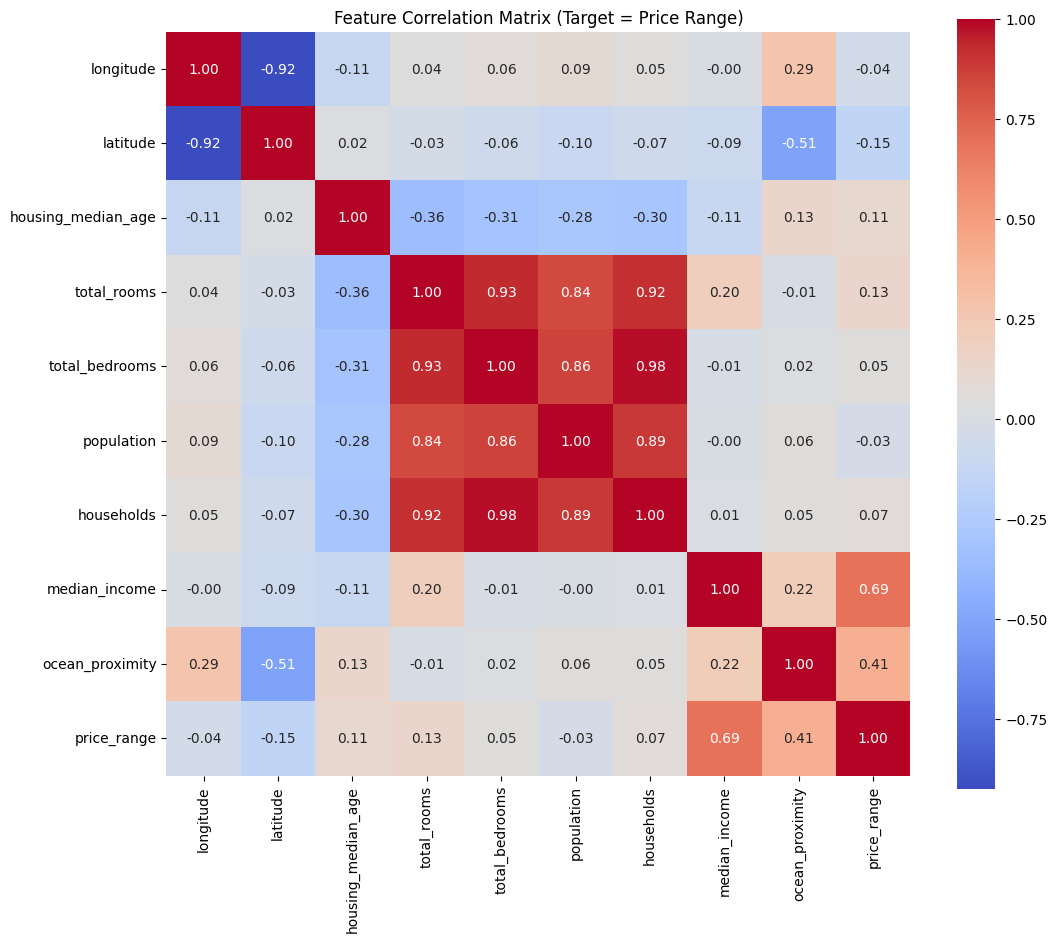

Highly Correlated Columns:
latitude and longitude with correlation: -0.924332822960481
total_bedrooms and total_rooms with correlation: 0.9292556339393624
households and total_rooms with correlation: 0.9158912883080367
households and total_bedrooms with correlation: 0.9778343244346747


In [36]:
corr_matrix = housing.corr()

import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix (Target = Price Range)')
plt.show()

threshold = 0.9
high_corr_pairs = [] 

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_1 = corr_matrix.columns[i]
            colname_2 = corr_matrix.columns[j]
            high_corr_pairs.append((colname_1, colname_2, corr_matrix.iloc[i, j]))

print("Highly Correlated Columns:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]} with correlation: {pair[2]}")

Separate target and features

In [37]:
housing = housing.dropna()
X = housing.drop(columns=['price_range']) 
Y = housing[['price_range']]              

# Save to CSV files
X.to_csv('X.csv', index=False)
Y.to_csv('Y.csv', index=False)

print("Files saved: X.csv (features) and Y.csv (target)")

Files saved: X.csv (features) and Y.csv (target)


PCA implemented

Explained variance ratio for each principal component:
Component 1: 0.4308 (43.08% of total variance)
Component 2: 0.2434 (24.34% of total variance)
Component 3: 0.1228 (12.28% of total variance)
Component 4: 0.1086 (10.86% of total variance)
Component 5: 0.0627 (6.27% of total variance)
Component 6: 0.0185 (1.85% of total variance)
Component 7: 0.0070 (0.70% of total variance)
Component 8: 0.0043 (0.43% of total variance)
Component 9: 0.0018 (0.18% of total variance)


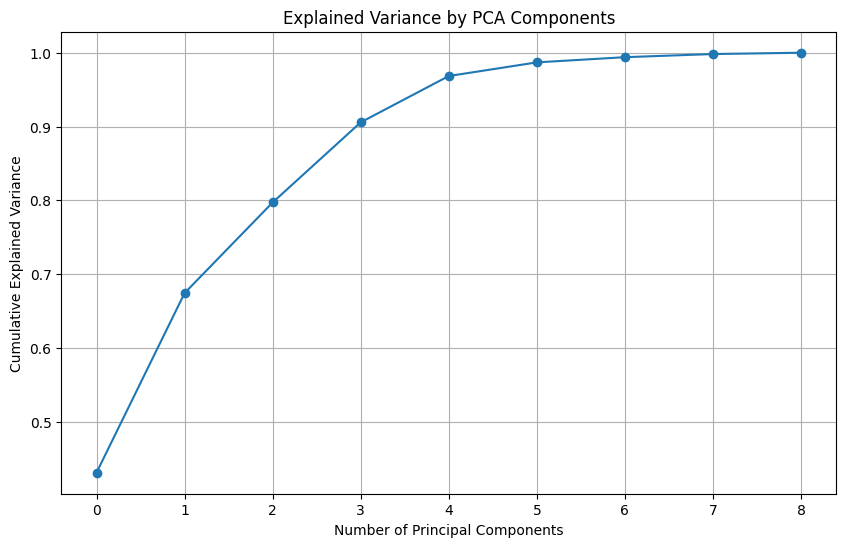

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = pd.read_csv('X.csv')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio for each principal component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Component {i+1}: {var:.4f} ({var*100:.2f}% of total variance)")
    
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


In [39]:
X_pca_5 = X_pca[:, :5]
print("Shape of reduced X_pca_5:", X_pca_5.shape)
cumulative_variance_5 = np.sum(pca.explained_variance_ratio_[:5])
print(f"Cumulative explained variance of first 5 principal components: {cumulative_variance_5:.4f} ({cumulative_variance_5*100:.2f}%)")

Shape of reduced X_pca_5: (10214, 5)
Cumulative explained variance of first 5 principal components: 0.9684 (96.84%)


Elbow Method finding optimal K

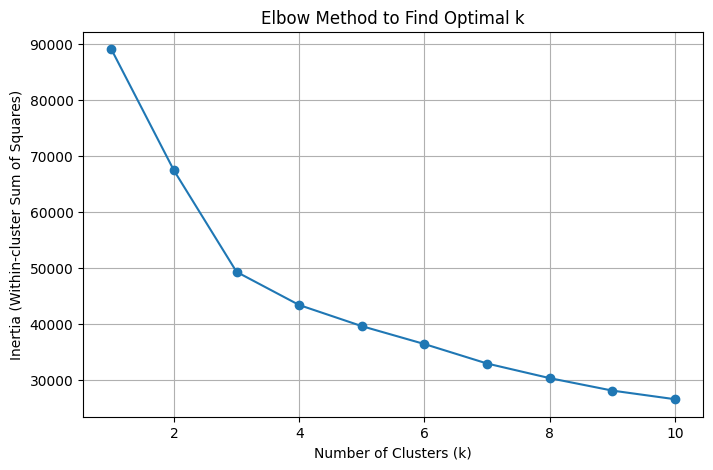

In [40]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
cluster_range = range(1, 11) 

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_5)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method to Find Optimal k')
plt.grid(True)
plt.show()

implement KMean clustering

In [41]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca_5)

unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3952, 1: 4340, 2: 261, 3: 1661}


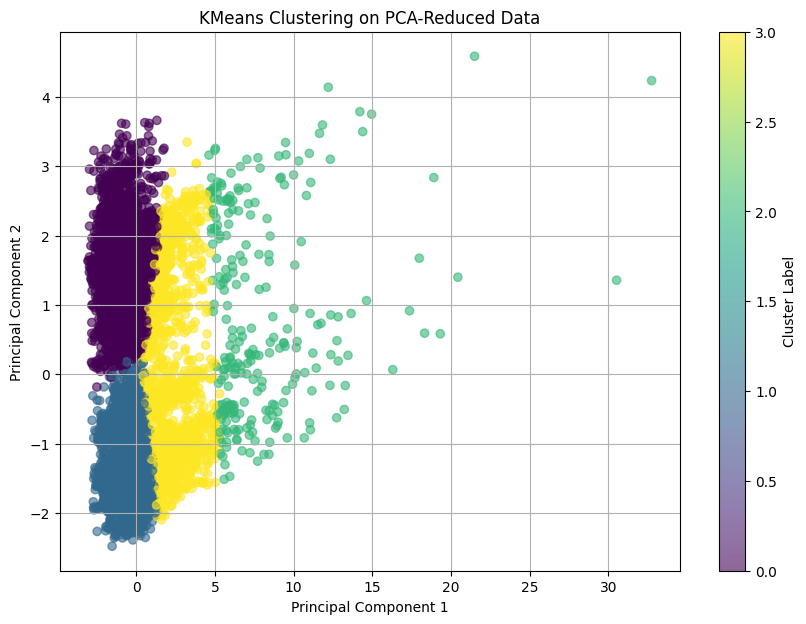

In [42]:
plt.figure(figsize=(10,7))
plt.scatter(X_pca_5[:, 0], X_pca_5[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering on PCA-Reduced Data')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

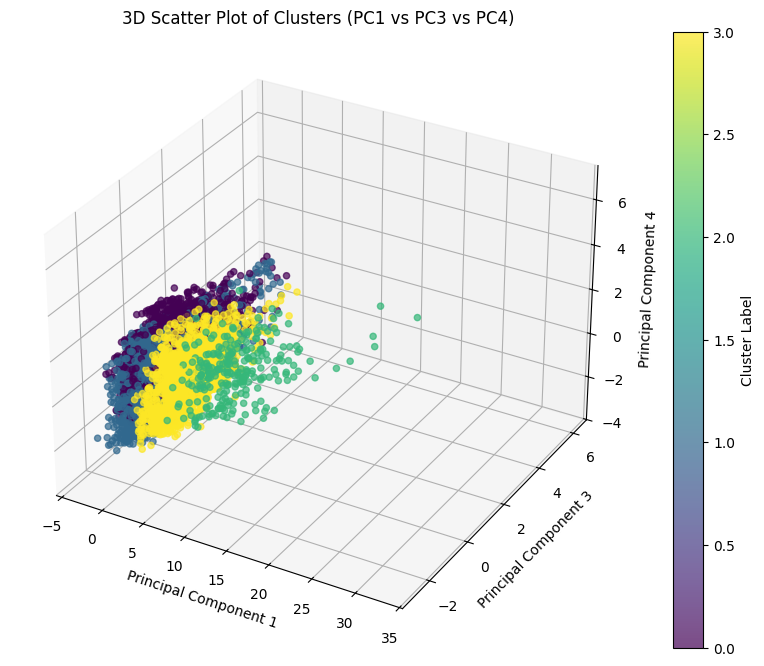

In [43]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_5[:, 0],  # PC1
    X_pca_5[:, 2],  # PC3
    X_pca_5[:, 3],  # PC4
    c=clusters, 
    cmap='viridis', 
    alpha=0.7
)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 3')
ax.set_zlabel('Principal Component 4')

ax.set_title('3D Scatter Plot of Clusters (PC1 vs PC3 vs PC4)')
fig.colorbar(scatter, label='Cluster Label')

# Show plot
plt.show()

Add clustering as a feature by adding distance to cluster centers


In [44]:
cluster_distances = kmeans.transform(X_pca_5)
distance_df = pd.DataFrame(cluster_distances, columns=[f'distance_to_cluster_{i}' for i in range(cluster_distances.shape[1])])
X_with_distances = pd.concat([X.reset_index(drop=True), distance_df.reset_index(drop=True)], axis=1)

output_path = 'X_with_cluster_distances.csv'
X_with_distances.to_csv(output_path, index=False)

print(f"Saved new features to {output_path}")

Saved new features to X_with_cluster_distances.csv
